<p align="center"> <img src="https://scholarlyoa.com/wp-content/uploads/2020/01/spam-email.png" width="500"> </p>  

# A simple, yet effective method to filter spam
## Using feature engineering  

I hate spam! and I believe most readers will agree with this statement. Our mailboxes are polluted by these useless and sometimes dangerous messages. They lead to fraud, let alone all the waste of resources. In the literature, this problem has been tackled in different ways. Machine learning-based techniques are largely used, and allow good performance in general. When I considered the spam filtering issue, the first thing I did was to read one (of too many...) messages I received lately.  
The message was an sms (text message) in french and was about some random unique offer that will expire soon, with a lot of exclamation marks and the usual formatting of good old spams. I realized that I categorized this message as spam, almost immediately after I saw it. The second thing was that, regardless of the language, I seem to look for the same characteristics every time I got spam.  
> In fact, I don't care about the content of the message!  

What makes the human analysis quick is its simplicity. The KISS principle at its finest!
<p align="center"> <img src="http://bmig.co.uk/wp-content/uploads/2015/10/kiss-848x450.jpg" width="500"> </p>  
In this article, I will present a spam filter, based on a rather simple approach. The algorithm will not contain any fancy natural language processing but will provide good results. The trick is the use of feature engineering.

## What is feature engineering?  
Feature engineering is a key step of data preprocessing. Using topic knowledge, we create, combine, select and/or modify the data features to obtain a less complex problem that could be solved using machine learning algorithms. A comprehensive explanation is presented by Jason Brownlee in his blog [Machine Learning Mastery](https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/).  

## 1st step: Get some data, and explore it
We will need labeled data of spam messages to train and evaluate machine learning algorithms. Data from [UCI Machine Learning Repository](https://archive-beta.ics.uci.edu/ml/datasets/228) contains 5574 labeled text message (sms). It is a good quality dataset developped and published by Almeida, Tiago in 2012.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm.notebook import tqdm
import urllib.request
from zipfile import ZipFile
# Setting plots parameters
%matplotlib inline
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['figure.figsize'] = (18, 10)
matplotlib.rcParams['figure.facecolor'] = '#00000000'
import warnings
warnings.filterwarnings("ignore")
from numpy.random import seed
seed(1) # in order to get the same results in every execution

In [2]:
# download data from UCI
# ref https://archive-beta.ics.uci.edu/ml/datasets/228
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
urllib.request.urlretrieve(url, 'sms_spam.zip')
# extract file
with ZipFile('sms_spam.zip', 'r') as zipObj:
   zipObj.extract('SMSSpamCollection')

In [3]:
data_raw = pd.read_csv('SMSSpamCollection',sep='\t',names=['Category','Message'])
data_raw['Category']=data_raw['Category'].astype('category')
data_raw['Category_num'] = data_raw['Category'].cat.codes

Now that the data is ready for use, let's do a quick exploratory analysis. 

In [4]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Category      5572 non-null   category
 1   Message       5572 non-null   object  
 2   Category_num  5572 non-null   int8    
dtypes: category(1), int8(1), object(1)
memory usage: 54.6+ KB


In [5]:
data_raw.head(5)

,Category,Message,Category_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


The category 1 refers to spam messages. Let's see if dataset is balanced. 

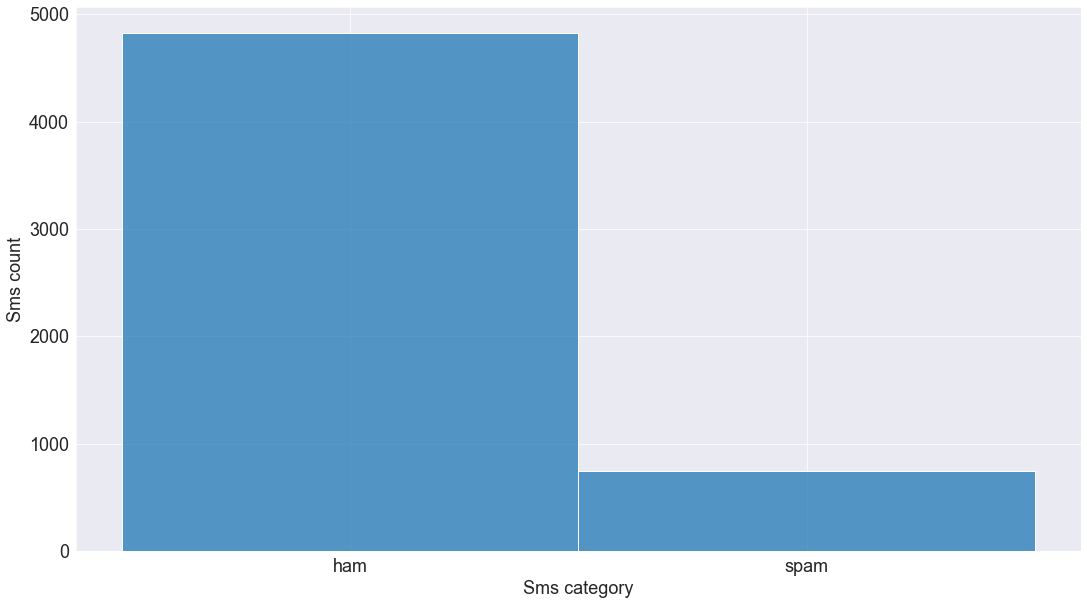

In [6]:
fig = sns.histplot(data_raw['Category']);
fig.set(ylabel = 'Sms count', xlabel = 'Sms category', Title='');

They are more non spam (ham) messages. This could affect the training and must be considered when we will split data into training and testing sets. The choice of evaluation metrics must take into account this property.  
Using this result, we can also define the baseline accuracy for the classification. If we predict non spam for all the messages, we will obtain 86.6% accuracy.

In [7]:
data_raw.groupby('Category')['Message'].count()/len(data_raw)

Category
ham     0.865937
spam    0.134063
Name: Message, dtype: float64

## Creating new features  
Let's observe some spam messages: 

In [8]:
data_raw[data_raw['Category']=='spam'].head(5)['Message'].values

array(["Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
       "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv",
       'WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.',
       'Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030',
       'SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info'],
      dtype=object)

We can spot some common elements in these messages:
- Numbers (phone numbers)
- Lots of symbols and ponctuations
- More capital letters than needed ...

In order to quantify those observations, let's define six functions: 

In [9]:
#extract the basic characters of the texts
lowercase ='abcdefghijklmnopqrstuvwxyz'
uppercase ='ABCDEFGHIJKLMNOPQRSTUVWXYZ'
symbols='#!/\$%?&*()_+-^[]{|}><~;:.,»«@£="'+"'"
numbers='0123456789'

def lower_score(text):
    # returns the ratio of lower case letters with respect to the message length
    return sum([char_ in lowercase for char_ in text])/len(text)

def upper_score(text):
    # returns the ratio of upper case letters with respect to the message length
    return sum([char_ in uppercase for char_ in text])/len(text)

def symbol_score(text):
    # returns the ratio of symbols and ponctuations with respect to the message length
    return sum([char_ in symbols for char_ in text])/len(text)

def number_score(text):
    # returns the ratio of numbers with respect to the message length
    return sum([char_ in numbers for char_ in text])/len(text)

def space_score(text):
    # returns the ratio of spaces and ponctuations with respect to the message length
    return sum([char_ in ' ' for char_ in text])/len(text)

def length(text):
    # returns the length of the message
    return len(text)

Using these functions, we create new columns (features).

In [10]:
data_raw['lower_score'] = data_raw['Message'].apply(lower_score)
data_raw['upper_score'] = data_raw['Message'].apply(upper_score)
data_raw['number_score'] = data_raw['Message'].apply(number_score)
data_raw['symbol_score'] = data_raw['Message'].apply(symbol_score)
data_raw['space_score'] = data_raw['Message'].apply(space_score)
data_raw['length'] = data_raw['Message'].apply(length)

Let's look at the results:

In [11]:
data_raw.head(5)

,Category,Message,Category_num,lower_score,upper_score,number_score,symbol_score,space_score,length
0,ham,"Go until jurong point, crazy.. Available only ...",0,0.720721,0.027027,0.00000,0.081081,0.171171,111
1,ham,Ok lar... Joking wif u oni...,0,0.551724,0.068966,0.00000,0.206897,0.172414,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,0.561290,0.064516,0.16129,0.038710,0.174194,155
3,ham,U dun say so early hor... U c already then say...,0,0.632653,0.040816,0.00000,0.122449,0.204082,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,0.737705,0.032787,0.00000,0.032787,0.196721,61


In the next section, we will use logistic regression to design the spam filter. Standardizing the features will prevent numerical issues that could affect the gradient descent algorithm. 

In [12]:
# standardize all newly created features
std_g = np.std(data_raw['length'])
mean_g = np.mean(data_raw['length'])
data_raw['length_std'] = (data_raw['length']-mean_g)/std_g

std_l = np.std(data_raw['lower_score'])
mean_l = np.mean(data_raw['lower_score'])
data_raw['lower_score_std'] = (data_raw['lower_score']-mean_l)/std_l

std_c = np.std(data_raw['upper_score'])
mean_c = np.mean(data_raw['upper_score'])
data_raw['upper_score_std'] = (data_raw['upper_score']-mean_c)/std_c

std_n = np.std(data_raw['number_score'])
mean_n = np.mean(data_raw['number_score'])
data_raw['number_score_std'] = (data_raw['number_score']-mean_n)/std_n

std_s = np.std(data_raw['symbol_score'])
mean_s = np.mean(data_raw['symbol_score'])
data_raw['symbol_score_std'] = (data_raw['symbol_score']-mean_s)/std_s

std_p = np.std(data_raw['space_score'])
mean_p = np.mean(data_raw['space_score'])
data_raw['space_score_std'] = (data_raw['space_score']-mean_p)/std_p

We can get an intuition on how effective the newly-created features can be in classifying messages by comparing their averages for spam and ham messages:

In [13]:
data_raw.groupby('Category').mean()

,Category_num,lower_score,upper_score,number_score,symbol_score,space_score,length,length_std,lower_score_std,upper_score_std,number_score_std,symbol_score_std,space_score_std
Category,,,,,,,,,,,,,
ham,0,0.693129,0.058196,0.004241,0.061730,0.181630,71.482487,-0.150281,0.129469,-0.064744,-0.304418,0.040955,0.065530
spam,1,0.563916,0.110913,0.116537,0.044052,0.164493,138.670683,0.970690,-0.836261,0.418195,1.966286,-0.264537,-0.423267


The average value of each new feature is different for spam and non spam messages. This means that we can classify the messages using those properties.  
A visual (and better) way to verify our hypothesis can be achieved using scatter plots.

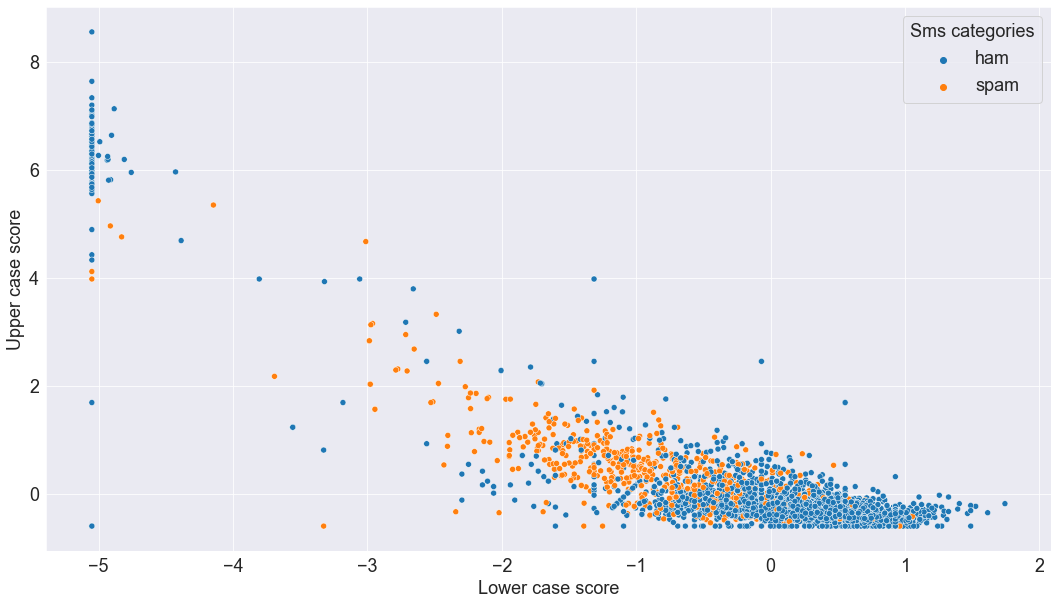

In [14]:
fig = sns.scatterplot(x='lower_score_std',y='upper_score_std',hue='Category',data=data_raw);
fig.set(ylabel = 'Upper case score', xlabel = 'Lower case score', Title='');
fig.legend(title='Sms categories');

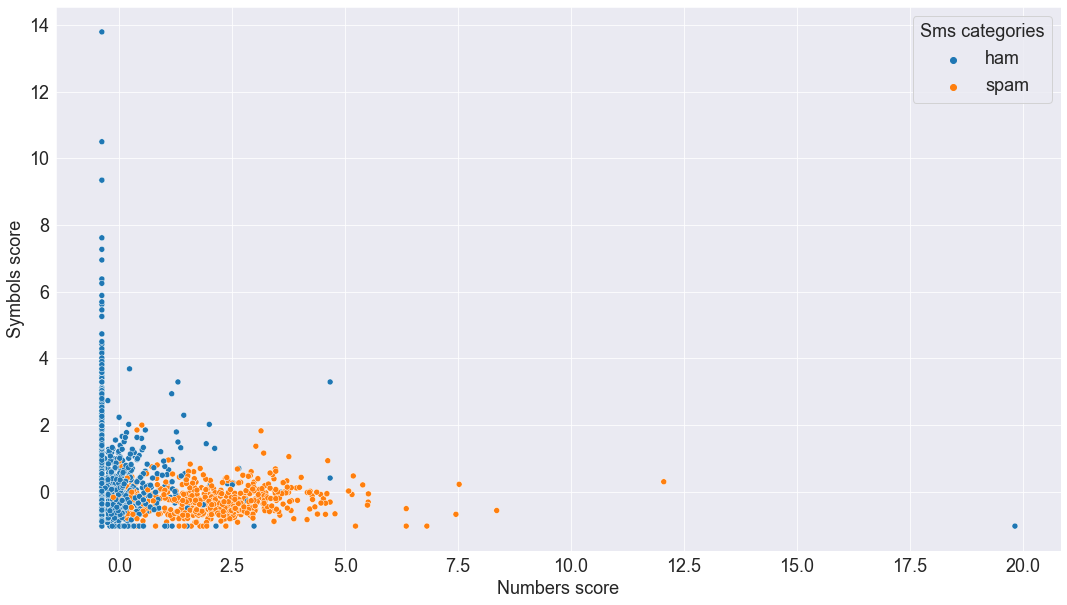

In [15]:
fig = sns.scatterplot(x='number_score_std',y='symbol_score_std',hue='Category',data=data_raw);
fig.set(ylabel = 'Symbols score', xlabel = 'Numbers score', Title='');
fig.legend(title='Sms categories');

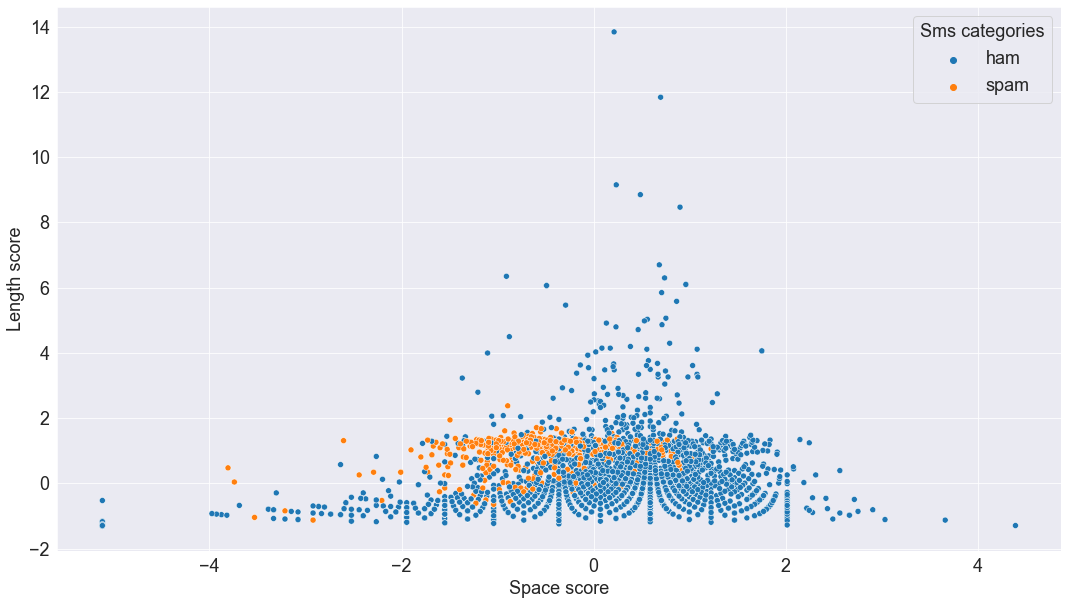

In [16]:
fig = sns.scatterplot(x='space_score_std',y='length_std',hue='Category',data=data_raw);
fig.set(ylabel = 'Length score', xlabel = 'Space score', Title='');
fig.legend(title='Sms categories');

The boundary between the spam/non spam messages is easy to determin visually. This Will make the classification problem simpler.  

Naturally, the next step is to try some machine learning algorithms!

## Classification of spam messages using machine learning algorithms
The data is split into three sets: a training, a validation and a test set. The first will be used to fit the algorithms to the data. The validation set will be used to tune hyperparameters. The test set will be used to evaluate the accuracy of the methods on unseen data.

In [17]:
from sklearn.model_selection import train_test_split
trainval_data, test_data = train_test_split(data_raw,test_size=0.2)
train_data, val_data = train_test_split(trainval_data,test_size=0.25)

Let's verify if the subsets contain the same ratio of spam/ham messages:

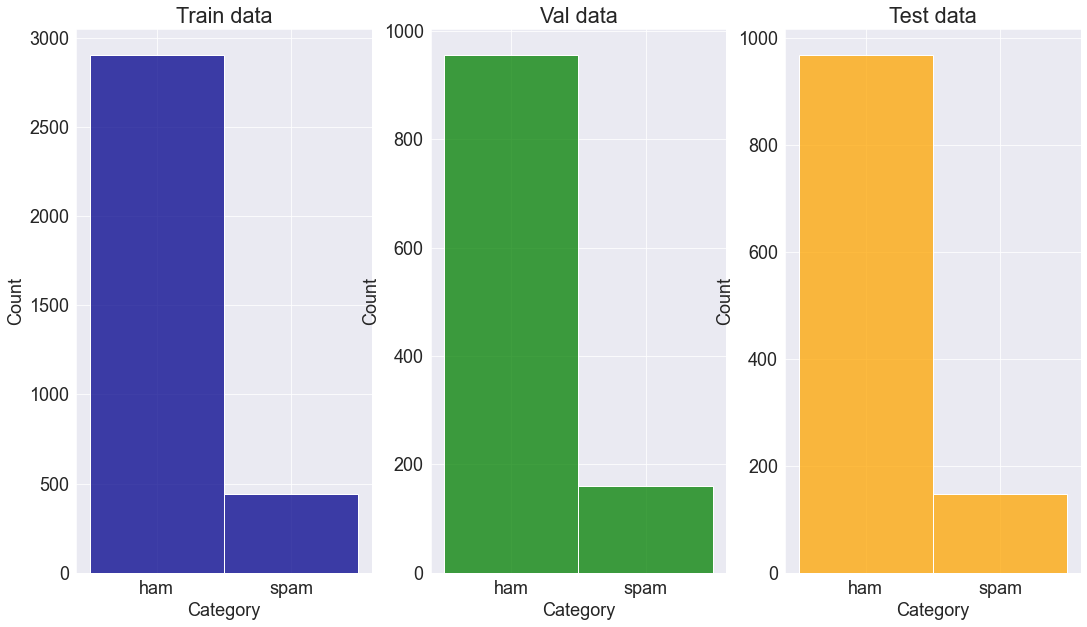

In [18]:
# check if the split is well distributed
plt.subplot(131);
fig = sns.histplot(train_data['Category'],color='darkblue');
fig.set_title('Train data');
plt.subplot(132);
fig= sns.histplot(val_data['Category'],color='green');
fig.set_title('Val data') ;
plt.subplot(133);
fig = sns.histplot(test_data['Category'],color='orange');
fig.set_title('Test data');


It turns out that `train_test_split` keeps the original distribution of the data. This is very convenient and *important*!  
Now, we isolate the features and labels:

In [19]:
# create train and test sets
in_cols = ['lower_score_std','upper_score_std','number_score_std','symbol_score_std','length_std','space_score_std']

train_features =train_data[in_cols]
train_labels = train_data['Category_num']


val_features =val_data[in_cols]
val_labels = val_data['Category_num']

test_features =test_data[in_cols]
test_labels = test_data['Category_num']

### Logistic regression
The first algorithm we will train is one of the most basic methods of classification: **logistic regression**, using `Sci-Kit learn` library.

In [20]:
# logistic regression 
from sklearn.linear_model import LogisticRegression 
logistic_classifier = LogisticRegression(max_iter=100)
logistic_classifier.fit(train_features,train_labels);

First, let's see how the logistic regression classifier performs on the training data:

In [21]:
print('Accuracy on training set')
logistic_classifier.score(train_features,train_labels)

Accuracy on training set


0.964691801316577

96% is way better than the baseline accuracy (86.6%), but the important information to get is how the classifier performs on new data:

In [22]:
print('Accuracy on testing set')
logistic_classifier.score(test_features,test_labels)

Accuracy on testing set


0.9641255605381166

An accuracy of 96% is a good result. However, the dataset is not balanced, so accuracy can be misleading. One way to tackle this problem is to choose metrics that are adapted to unbalanced data. **Recall** and **Precision** will be used in our analysis. More details are available [here](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall).

In [23]:
from sklearn.metrics import recall_score, precision_score
test_pred = logistic_classifier.predict(test_features)
print("Recall score for logistic regression: {:.2f}".format(recall_score(test_labels,test_pred)))
print("Precision score for logistic regression: {:.2f}".format(precision_score(test_labels,test_pred)))

Recall score for logistic regression: 0.79
Precision score for logistic regression: 0.93


Let's take a look at the regression coefficients, 

In [24]:
print('Classifier coefficients (weights)')
logistic_classifier.coef_

Classifier coefficients (weights)


array([[ 0.14871548,  0.23016731,  2.57034147, -1.15027591,  0.64083334,
        -0.54815462]])

It appears that the features are numerically well balanced, as the weights are -in general- of the same order of magnitude.  
### K-nearest neighbors
Based on the same library and methodology, we solve the problem using the **KNN** algorithm. This algorithm has a hyperparameter `n_neighbor` which refers to the number of neighbors that are used to predict the output. 

In [25]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
classifiers = []
accuracies = []
for n_neighbors in range(1,21):
    KNN_classifier_i = KNeighborsClassifier(n_neighbors=n_neighbors)
    KNN_classifier_i.fit(train_features,train_labels);
    acc_val = KNN_classifier_i.score(val_features,val_labels)
    classifiers.append([KNN_classifier_i, n_neighbors])
    accuracies.append(acc_val)
# choose the classifier with the maximal accuracy
accuracies_max = np.argmax(accuracies)
KNN_classifier = classifiers[accuracies_max][0]
print('best n_neighbors = ',classifiers[accuracies_max][1])

best n_neighbors =  7


In [26]:
acc_test = KNN_classifier.score(test_features,test_labels)
print('Accuracy on testing set for KNN: {:.2f}'.format(acc_test))
test_pred = KNN_classifier.predict(test_features)
print("Recall score for KNN: {:.2f}".format(recall_score(test_labels,test_pred)))
print("Precision score for KNN: {:.2f}".format(precision_score(test_labels,test_pred)))

Accuracy on testing set for KNN: 0.99
Recall score for KNN: 0.90
Precision score for KNN: 0.99


The results obtained using KNN are better than logistic regression, in terms of accuracy and recall. 

### Naive Bayes classification
The third method we will test is based on Bayes theory. Many real world applications for spam filtering are based on this method. We will not perform hyperparameters tunning with this method.

In [27]:
# naive bayes
from sklearn.naive_bayes import GaussianNB 
NaiveBayes_classifier = GaussianNB()
NaiveBayes_classifier.fit(train_features,train_labels);

In [28]:
acc_test = NaiveBayes_classifier.score(test_features,test_labels)
print('Accuracy on testing set for Naive Bayes classifier: {:.2f}'.format(acc_test))
test_pred = NaiveBayes_classifier.predict(test_features)
print("Recall score for Naive Bayes classifier: {:.2f}".format(recall_score(test_labels,test_pred)))
print("Precision score for Naive Bayes classifier: {:.2f}".format(precision_score(test_labels,test_pred)))

Accuracy on testing set for Naive Bayes classifier: 0.98
Recall score for Naive Bayes classifier: 0.86
Precision score for Naive Bayes classifier: 0.98


The precision score of the Naive-Bayes classifier is better than KNN, while the opposite happens with the recall score. This is frequent in machine learning problems, where we have to settle a tradeoff between precision and recall. 

### Decision trees
Decision trees are simple to implement and can be very efficient in classification problems. Decision trees can be tuned using multiple hyperparameters. In this study, we will tune `max_depth` parameter.

In [29]:
# decision trees
from sklearn.tree import DecisionTreeClassifier
classifiers = []
accuracies = []
for max_depth in range(1,50):
    DT_classifier_i = DecisionTreeClassifier(max_depth = max_depth, random_state=42)
    DT_classifier_i.fit(train_features,train_labels);
    acc_val = DT_classifier_i.score(val_features,val_labels)
    classifiers.append([DT_classifier_i, max_depth])
    accuracies.append(acc_val)
# choose the classifier with the maximal accuracy
accuracies_max = np.argmax(accuracies)
DT_classifier = classifiers[accuracies_max][0]
print('best max_depth = ',classifiers[accuracies_max][1])

best max_depth =  7


In [30]:
acc_test = DT_classifier.score(test_features,test_labels)
print('Accuracy on testing set for Decision tree classifier: {:.2f}'.format(acc_test))
test_pred = DT_classifier.predict(test_features)
print("Recall score for decicion tree classifier: {:.2f}".format(recall_score(test_labels,test_pred)))
print("Precision score for decicion tree classifier: {:.2f}".format(precision_score(test_labels,test_pred)))

Accuracy on testing set for Decision tree classifier: 0.97
Recall score for decicion tree classifier: 0.89
Precision score for decicion tree classifier: 0.89


### Feed forward neural network 
The last method we will test, is neural feed forward networks. We will implement a simple network of two hidden layers of 5 neurons and one output layer using sigmoid activation (appropriate for binary classification). Tensorflow platform will be used, with KERAS API. 

In [31]:
# a basic feed forward neural network using Keras/Tensorflow

# building the net using keras
from keras import models
from keras import layers

network = models.Sequential()
network.add(layers.Dense(10 , activation='relu' , input_dim=6)) #1st hidden layer
network.add(layers.Dense(10 , activation='relu')) #2nd hidden layer
network.add(layers.Dense(1, activation='sigmoid')) # outplut layer

network.compile(optimizer='adam', loss='binary_crossentropy',metrics=['acc','Precision','Recall'])

# Training 
n_epochs =50
result = network.fit(train_features,train_labels,epochs = n_epochs,verbose=0,validation_data= (val_features,val_labels),shuffle=False)

In [32]:
# to avoid overfitting, choose the number of epochs that maximize the validation accuracy
n_epochs_opt = np.argmax(result.history['val_acc'])+1
print('Optimal number of epochs = ', n_epochs_opt)
# we train again the network with the optimal epochs number
network = models.Sequential()
network.add(layers.Dense(5 , activation='relu' , input_dim=6)) #1st hidden layer
network.add(layers.Dense(5 , activation='relu')) #2nd hidden layer
network.add(layers.Dense(1, activation='sigmoid')) # outplut layer

network.compile(optimizer='adam', loss='binary_crossentropy',metrics=['acc','Precision','Recall'])

# Training 
n_epochs = n_epochs_opt
result = network.fit(train_features,train_labels,epochs = n_epochs,verbose=0,validation_data= (val_features,val_labels),shuffle=False)

Optimal number of epochs =  24


In [33]:
# show the metrics on the test data
nn_test_outputs = np.round(network.predict(test_features))
test_preds = np.reshape(nn_test_outputs,(1,-1))[0]
acc_test = np.sum(test_preds== test_labels)/len(test_labels)
print('Accuracy on testing set for Neural Network: {:.2f}'.format(acc_test))
print("Recall score for Neural Network: {:.2f}".format(recall_score(test_labels,test_preds)))
print("Precision score for Neural Network: {:.2f}".format(precision_score(test_labels,test_preds)))

Accuracy on testing set for Neural Network: 0.98
Recall score for Neural Network: 0.89
Precision score for Neural Network: 0.96


### Ensemble method

In [45]:
myclassifiers = [logistic_classifier, KNN_classifier, NaiveBayes_classifier, DT_classifier]
predictions=[]
for test_sample in test_features.values:
    result=0
    for classifier in myclassifiers:
        result += classifier.predict(np.reshape(test_sample,(1,6)))
    predictions.append(np.round(result/len(myclassifiers)))

In [46]:
test_preds =np.reshape(predictions,(1,-1))[0]
acc_test = np.sum(test_preds== test_labels)/len(test_labels)
print('Accuracy on testing set for ensemble classifier: {:.2f}'.format(acc_test))
print("Recall score for ensemble classifier: {:.2f}".format(recall_score(test_labels,test_preds)))
print("Precision score for ensemble classifier: {:.2f}".format(precision_score(test_labels,test_preds)))

Accuracy on testing set for ensemble classifier: 0.98
Recall score for ensemble classifier: 0.85
Precision score for ensemble classifier: 1.00


## Comparison of the metrics
In this table are shown the accuracy, recall, precision for all the classification methods.

| Algorithm       | Accuracy     | Recall     | Precision     |
| :------------- | :----------: | -----------: |  -----------: |
|  Logistic regression | 0.96   | 0.79    | 0.93    |
| K-Nearest neighbors | 0.99   | 0.90    | 0.99    |
| Naive Bayes | 0.98  | 0.86    | 0.98    |
| Decision trees | 0.97   | 0.89    | 0.89    |
| FF Neural network   | 0.98 | 0.88 |0.94 | 
| Ensemble method   | 0.98 | 0.85 |1.00 |    
  
All the methods show good performance, with regards to the metrics. The neural network which is more complex to train and implement shows a better performance. It turns out that the problem is numerically simple, so using complex algorithm doesn't improve significantly the performance. Each method has pros and cons. The choice depends ultimately on the end user and the environment.   

## Summary and future work  
In this notebook, the problem of filtering SMS spam has been tackled using a feature engineering approach. We have developed new features, based on simple observations:
* The ratio of capital letters
* The ratio of numbers and symbols  
  
Using these features, we implemented multiple machine learning classification algorithms. The tests showed good results, while the problem formulation remained simple.
In the future, we will apply this approach to more complex text classification problems. We will focus also on hyperparameters tunning and will test other machine learning techniques.

## References and links  
- Machine learning mastery blog by Jason Brownlee [https://machinelearningmastery.com]
- UCI Machine Learning Repository [https://archive-beta.ics.uci.edu/ml/datasets/228]
- Google machine learning crash course [https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall]
- My Github [https://github.com/zaitrik]
- My LinkedIn [https://www.linkedin.com/in/mounir-kara-zaitri-a01a00208/]